In [1]:
import matplotlib.pyplot as plt
import csv
import sys
sys.path.insert(1, '/home/kirant/thinglap/NSHM-projects/distr-seismicity-models')
import grids.grids as grids
import zones as zones

### Determine if a given point (lon, lat, dep) is within slab or interface. 


The idea would be:  <br/>
(1) is depth is surely crustal?  <br/>
(1) Is longitude and latitude within bounds of subduction zone,  <br/>
(2) If so, is the depth wthin slab, and if not, interface 

In [1]:
# a test addition - 

def read_interfacemodel(subduction):
    if subduction =='hik':
        interface_model = '../subduction/hikinterfacegrid.csv'
    elif subduction == 'puy':
        interface_model = '../subduction/puyinterfacegrid.csv'
    depth_cutoff = 40
    
    slon, slat, sdep = ([],[],[])
    with open(interface_model, 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        header = next(csvreader)
        for row in csvreader:
            if (float(row[2])< depth_cutoff):
                slon.append(float(row[0]))
                slat.append(float(row[1]))
                sdep.append(float(row[2]))
    return slon, slat, sdep

In [2]:
from scipy.interpolate import interp2d
import numpy as np
import kpolygon.polygon as poly

def interface_depth_function(interface_model=None):
    if interface_model is None:
        interface_model = '../subduction/hikinterfacegrid.csv'

    depth_cutoff = 40
    
    slon, slat, sdep = ([],[],[])
    with open(interface_model, 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        header = next(csvreader)
        for row in csvreader:
            if (float(row[2])< depth_cutoff):
                slon.append(float(row[0]))
                slat.append(float(row[1]))
                sdep.append(float(row[2]))
            
    fintp = interp2d(np.array(slon), np.array(slat), np.array(sdep), kind='linear')
    blon, blat = poly.boundary(slon, slat)
    return(fintp, (blon, blat))


In [19]:
def interface_config(subduction='hik'):
    # retrun depth function (interpolation) and polygon bounds
    if subduction=='hik':
        ifmodel = '../subduction/hikinterfacegrid.csv'
    elif subduction=='puy':
        ifmodel = '../subduction/puyinterfacegrid.csv'
    else:
        print("subduction not found!")
        return None, None
    
    fintp, ifbounds = interface_depth_function(interface_model=ifmodel)
    blon, blat = ifbounds
    pbounds = zones.get_boundpolygon(blon, blat)
    
    return fintp, pbounds

#
def get_interface_configs():
    interface_configs = {}
    fintp, pbounds =  interface_config('hik')
    interface_configs.update({'hik': {'fintp': fintp, 'pbounds': pbounds}})
    fintp, pbounds =  interface_config('puy')
    interface_configs.update({'puy': {'fintp': fintp, 'pbounds': pbounds}})
    return interface_configs

#
def get_regime(lon, lat, dep, fintp, pbounds, interface_buffer):
    if not zones.is_within_zone(lon, lat, pbounds):
        regime = 0
    else:
        pdep = fintp(lon, lat)
        # check whether interface
        if (dep<(pdep-interface_buffer[0])):
            regime = 1
        elif (dep<=(pdep+interface_buffer[1])):
            regime = 2
        else:
            regime = 3
            
    return regime

#
def get_nzregime(lon, lat, dep, interface_configs = None, interface_buffer = [5,5]):
    # interface_configs is a dictionary of 
    # depth function (interpolation) and polygon bounds
    # regime = 0 for shallow crust (outside subduction), 1 for crust above subduction
    # 2 for interface and 3 for slab
    # first check is within bounds
    
    if interface_configs is None:
        interface_configs = get_interface_configs()
        return interface_configs
    
    regime = 0
    interface = [k for k in interface_configs.keys()]
    #
    fintp = interface_configs[interface[0]]['fintp']
    pbounds = interface_configs[interface[0]]['pbounds']
    regime = get_regime(lon, lat, dep, fintp, pbounds, interface_buffer)
    
    if regime == 0:
        fintp = interface_configs[interface[1]]['fintp']
        pbounds = interface_configs[interface[1]]['pbounds']
        regime = get_regime(lon, lat, dep, fintp, pbounds, interface_buffer)
    # first check hik
    return regime
    

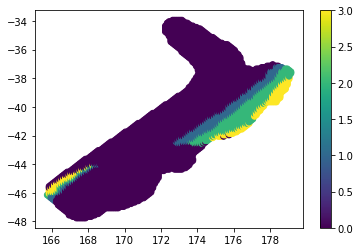

In [22]:
# test
glon, glat = grids.get_sample_grid(file = '../grids/samplegrid.txt')
gdep = [15]*len(glon)

interface_configs = get_interface_configs()
regime = []
for i in range(len(glon)):
    glon[i], glat[i]
    rgm = get_nzregime(glon[i], glat[i], gdep[i], \
                          interface_configs = interface_configs)
    regime.append(rgm)

plt.scatter(glon, glat, c=regime)
plt.colorbar();